# Chapter 7
## Detection Using Neural Networks

In [1]:
import os, sys
import numpy as np
from math import floor
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
import multiprocessing as mp


from sklearn import model_selection,preprocessing
# os.environ['THEANO_FLAGS'] = "device=cuda,force_device=True,floatX=float32"
# os.environ["KERAS_BACKEND"] = "theano"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1,l2, l1_l2
from keras.utils import plot_model, np_utils



# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from yolo_data_aug import YOLODataAug
from yolo_detector import YOLODetector
from nn_detector import NeuralNetworkDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)


linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

# use gpu
# print('GPUs:',K.tensorflow_backend._get_available_gpus())
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


##  **6.2 Classifier Design**

### Dataset

**Generate Dataset**

In [2]:
transforms, transforms_params = ['slice', 'scale'], [[1.5,9.5],[0,1]]
# transforms, transforms_params = ['slice', 'zscore','scale'], [[1.5,9.5],None,[0,1]]
nn = NeuralNetworkDetector(dataset_loc, database_loc, site, transforms, transforms_params)
name = 'cnn'
cut_params = [1,0.2,8,1.5,1]
# database.create_cuts_db_mp(transforms, transforms_params,cut_params, verbose=True, noise=True, train=True, test=False, n=None)

**Show dataset statistics**

In [3]:
_ = database.stats(transforms, transforms_params,cut_params, noise=True, test=False)

/srv/home/knnoth001/wdml/data/databases/awdEvents1/marion/marion_h5/['slice', 'scale']_[[1.5, 9.5], [0, 1]]_[1, 0.2, 8, 1.5, 1]_True/train
samples:  7968


100%|██████████| 7968/7968 [00:08<00:00, 907.07it/s]



Database statistics               
min                   0           
max                   1           
mean                  0.579       
std                   0.112       
noise                 2850[35.77%]
whistler              5118[64.23%]
total                 7968        



**Load dataset**

In [3]:
X , Y = database.load_cuts_db_mp(transforms, transforms_params,cut_params, noise=True, verbose=True, test=False, shuffle=True, random_state=42)

/srv/home/knnoth001/wdml/data/databases/awdEvents1/marion/marion_h5/['slice', 'scale']_[[1.5, 9.5], [0, 1]]_[1, 0.2, 8, 1.5, 1]_True/train
samples:  7968


100%|██████████| 7968/7968 [00:05<00:00, 1430.94it/s]


**Show few examples**

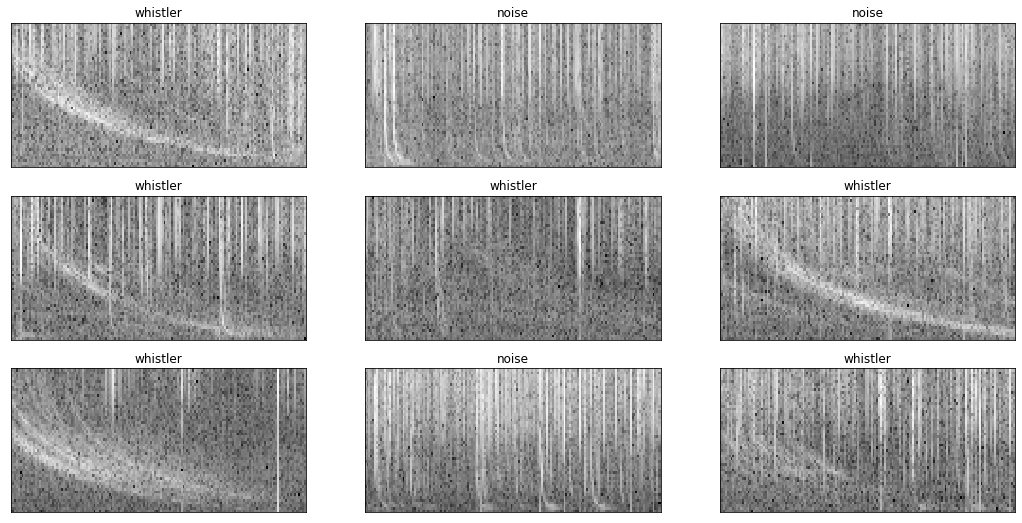

In [4]:
x_size = 3
y_size = 3
scale = 3
plt.figure(figsize=(y_size*2*scale, x_size*scale))
for ix in range(x_size*y_size):
    ax = plt.subplot(x_size, y_size, ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(len(Y))
    plt.pcolormesh(X[index], cmap='gray')
    ax.set_title('whistler' if Y[index]==1 else 'noise')
plt.show()

**Reshape data and label and rescale it**

In [5]:
freq_len, time_len = X[0].shape
data = X.reshape(len(X),freq_len*time_len)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = data.reshape((len(data),1,freq_len,time_len))
evt = np_utils.to_categorical(Y)
print(X.shape, Y.shape)
print(data.shape,evt.shape)
print(Y)

# save scaler
nn.save_scaler(scaler, name=name)

(7968, 52, 156) (7968,)
(7968, 1, 52, 156) (7968, 2)
[False False False ...  True  True  True]
Saving scaler .... Done.


**Define Model**

In [25]:
model = Sequential()
model.add(Conv2D(2,(int(freq_len/2), int(time_len/2)), input_shape=(1,freq_len, time_len),
                    padding='same', activation='relu',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Dropout(rate=0.2))
model.add(Conv2D(4, (21,21), activation='relu', padding='same',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Dropout(rate=0.3))
model.add(Conv2D(8, (9,9), activation='relu', padding='same',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Dropout(rate=0.3))
model.add(Conv2D(16, (5,5), activation='relu', padding='same',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
# model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(2, activation='softmax'))

#compile model
epochs = 30
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 2, 52, 156)        4058      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 2, 26, 78)         0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 2, 26, 78)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 26, 78)         3532      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 4, 13, 39)         0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 4, 13, 39)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 13, 39)        

**Train Model**

In [26]:
history = model.fit(data, evt, validation_split=0.3, epochs=epochs, batch_size=250, shuffle=True)

Train on 5577 samples, validate on 2391 samples
Epoch 1/30
5577/5577 [==============================] - 3s 500us/sample - loss: 0.6728 - accuracy: 0.6041 - val_loss: 0.6516 - val_accuracy: 0.6512
Epoch 2/30
5577/5577 [==============================] - 2s 333us/sample - loss: 0.6225 - accuracy: 0.6380 - val_loss: 0.6099 - val_accuracy: 0.6512
Epoch 3/30
5577/5577 [==============================] - 2s 332us/sample - loss: 0.5805 - accuracy: 0.6421 - val_loss: 0.5589 - val_accuracy: 0.6683
Epoch 4/30
5577/5577 [==============================] - 2s 335us/sample - loss: 0.5192 - accuracy: 0.6909 - val_loss: 0.4674 - val_accuracy: 0.8214
Epoch 5/30
5577/5577 [==============================] - 2s 336us/sample - loss: 0.4384 - accuracy: 0.7827 - val_loss: 0.3588 - val_accuracy: 0.8653
Epoch 6/30
5577/5577 [==============================] - 2s 334us/sample - loss: 0.3552 - accuracy: 0.8454 - val_loss: 0.2842 - val_accuracy: 0.8942
Epoch 7/30
5577/5577 [==============================] - 2s 334us

**Save Model and its History**

In [27]:
# save history
nn.save_history(history, name=name)
# save model
nn.save_model(model, name=name)

Saving history .... Done.
Saving history .... Done.


**Plot history**

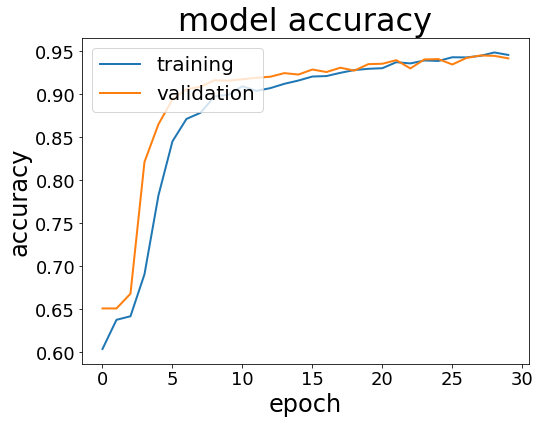

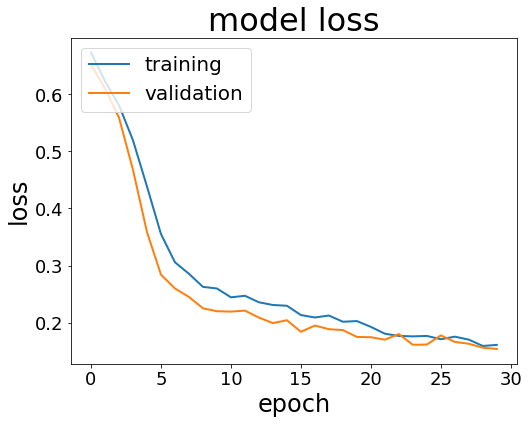

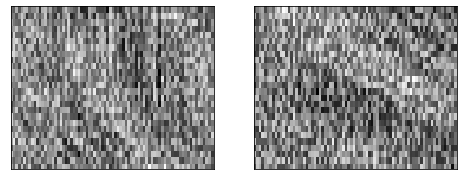

In [28]:
history = nn.load_history(name=name)
scaler = nn.load_scaler(name=name)
model = nn.load_model(name=name)
# summarize history for accuracy
nn.show_history(history, figsize=(8,6),font=font)
nn.visualization(model, figsize=(8,3), conv_layer_number=0)

**Visualise layers**

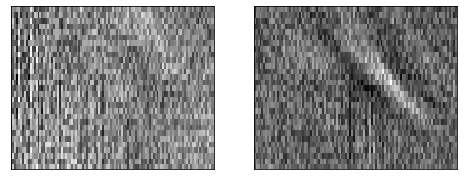

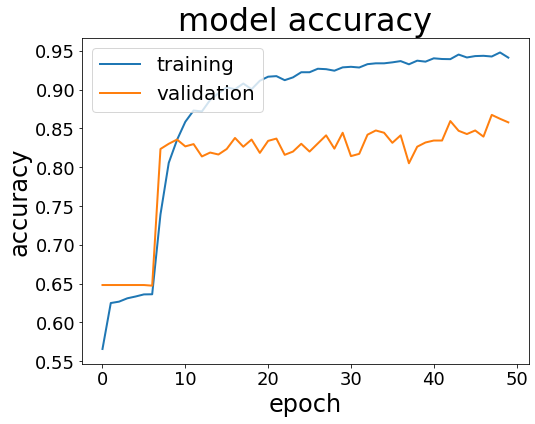

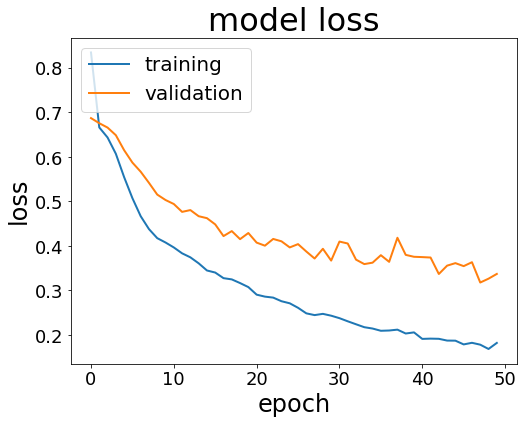

In [8]:
transforms, transforms_params = ['slice', 'scale'], [[1.5,9.5],[0,1]]
nn = NeuralNetwork(dataset_loc, database_loc, site, transforms, transforms_params)
model = nn.load_model(name=name)
history = nn.load_history(name=name)
nn.visualization(model, figsize=(8,3), conv_layer_number=0)
nn.show_history(history, figsize=(8,6),font=font)

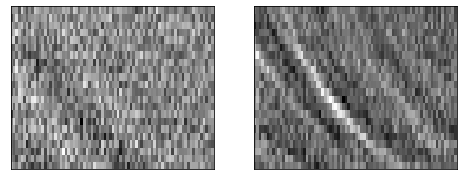

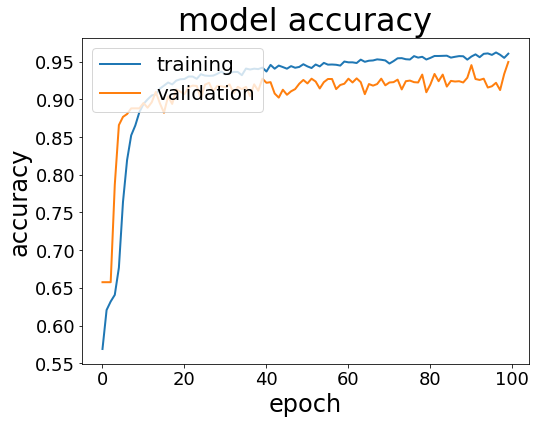

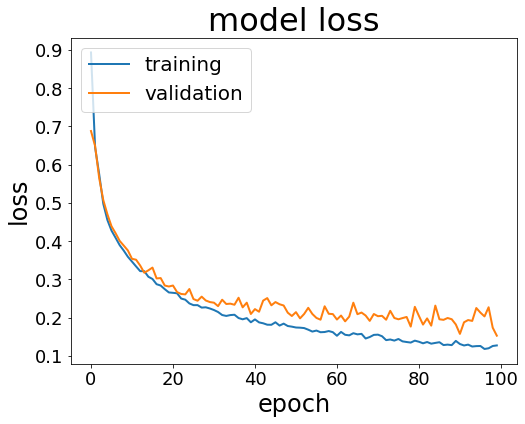

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 2, 44, 156)        3434      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 22, 78)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 22, 78)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 22, 78)         7064      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 11, 39)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 11, 39)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 11, 39)       

In [5]:
transforms, transforms_params = ['slice', 'zscore','scale'], [[1.5,9.5],None,[0,1]]
nn = NeuralNetworkDetector(dataset_loc, database_loc, site, transforms, transforms_params)
model = nn.load_model(name=name)
history = nn.load_history(name=name)
nn.visualization(model, figsize=(8,3), conv_layer_number=0)
nn.show_history(history, figsize=(8,6),font=font)
model.summary()

In [10]:
_, _, f,t = model.layers[0].input_shape
f,t

(44, 156)